In [1]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim
import pickle

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

/anaconda3/lib/python3.7/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


In [6]:
all_trax_df = pickle.load(open('all_trax_df.p', 'rb'))

In [138]:
# Convert to list
data = all_trax_df.annotations.values.tolist()

# Remove new line characters
data = [re.sub(r'\s+', ' ', annotation) for annotation in data]

# Remove single quotes
data = [re.sub(r"\'", "", annotation) for annotation in data]

# remove links
data = [re.sub(r"[-a-zA-Z0-9@:%_\+.~#?&//=]{2,256}\.[a-z]{2,4}\b(\/[-a-zA-Z0-9@:%_\+.~#?&//=]*)?", "", annotation) for annotation in data]

pprint(data[:1])

['A bit of a backstory to this remark about “the professors”… It so happens '
 'that academia tends to be supportive of Palestinian statehood. (I’m avoiding '
 'the term “pro Palestinian” as that and its counterpart, “pro Israel”, have '
 'taken on unfortunate connotations of being mutually exclusive from one '
 'another.) Instead of Dershowitz (et al.) addressing some of these points, '
 'the typical counter-argument is that there’s an anti-Semitic bias in '
 'academia (under the questionable logic that being pro Palestinian renders '
 'one anti-Israel, which renders one anti-Semitic; I know). At the time of '
 'this debate in November 2005, the anxiety about supposed academic '
 'anti-Semitism reached considerable heights, namely at Columbia University. A '
 'longtime vanguard of Arab intellectualism since the late scholar Edward '
 'Said, Columbia drew much scrutiny for the Palestinian sympathies of its '
 'leading Arab scholars, which spawned the controversial website Campus Watch 

In [139]:
all_trax_df.rename(index=str, columns={0:'annotations'},inplace=True)

# Tokenize and Simple Preprocess

In [140]:
def annotations_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(annotations_to_words(data))

print(data_words[:1])

[['bit', 'of', 'backstory', 'to', 'this', 'remark', 'about', 'the', 'professors', 'it', 'so', 'happens', 'that', 'academia', 'tends', 'to', 'be', 'supportive', 'of', 'palestinian', 'statehood', 'avoiding', 'the', 'term', 'pro', 'palestinian', 'as', 'that', 'and', 'its', 'counterpart', 'pro', 'israel', 'have', 'taken', 'on', 'unfortunate', 'connotations', 'of', 'being', 'mutually', 'exclusive', 'from', 'one', 'another', 'instead', 'of', 'dershowitz', 'et', 'al', 'addressing', 'some', 'of', 'these', 'points', 'the', 'typical', 'counter', 'argument', 'is', 'that', 'there', 'an', 'anti', 'semitic', 'bias', 'in', 'academia', 'under', 'the', 'questionable', 'logic', 'that', 'being', 'pro', 'palestinian', 'renders', 'one', 'anti', 'israel', 'which', 'renders', 'one', 'anti', 'semitic', 'know', 'at', 'the', 'time', 'of', 'this', 'debate', 'in', 'november', 'the', 'anxiety', 'about', 'supposed', 'academic', 'anti', 'semitism', 'reached', 'considerable', 'heights', 'namely', 'at', 'columbia', 'u

# Lemmatization

In [141]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for annotations in texts:
        doc = nlp(" ".join(annotations)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] 
                                   else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

['bit backstory remark professor so happen academia tend be supportive palestinian statehood avoid term palestinian counterpart have take unfortunate connotation be mutually exclusive instead dershowitz address point typical counter argument be there anti semitic bias academia questionable logic be pro palestinian render anti israel render anti semitic know time debate november anxiety suppose academic anti semitism reach considerable height namely columbia university longtime vanguard arab intellectualism late scholar edward say columbia draw much scrutiny palestinian sympathy lead arab scholar spawn controversial website campus watch start list dossier professor supposedly anti israel sentiment however much controversy publicly list dossier be akin hysterical mccarthyist witch hunt be take bandar mention bandar mention israeli disengagement gaza force removal israeli settler be not exactly altruistic compromise dershowitz be portray chemi shalev write israeli newspaper haaretz contin

# Create Document-Word Matrix

In [154]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum required occurences 
                                                               # of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

# Check Sparsity

In [155]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  2.70115292666938 %


# Build LDA model

In [156]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=10,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


# Evaluate Model Performance

In [157]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -5064638.404891492
Perplexity:  1972.4017613192534
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': -1,
 'n_topics': None,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


# Gridsearch

In [159]:
# Define Search Param
search_params = {'n_components': [10,11], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_components': [10, 11], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

# Best Model

In [160]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 10}
Best Log Likelihood Score:  -1772453.8268737078
Model Perplexity:  1941.533083942801


# Dominant Topics

In [149]:
'''
Major topics in green
'''

# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.7,0,0,0,0.18,0.08,0,0,0,0.04,0
Doc1,0.09,0,0.07,0,0.06,0.59,0.18,0,0,0,5
Doc2,0,0,0,0,0,0.97,0,0,0,0,5
Doc3,0.06,0,0,0,0,0.93,0,0,0,0,5
Doc4,0,0,0,0,0,1,0,0,0,0,5
Doc5,0.09,0,0,0.01,0.45,0.38,0,0.07,0,0,4
Doc6,0,0,0,0,0.47,0.42,0.02,0.08,0,0,4
Doc7,0.47,0.1,0,0,0,0.2,0.22,0,0,0,0
Doc8,0,0,0,0,0,0.99,0,0,0,0,5
Doc9,0.36,0,0,0,0.24,0,0,0,0.05,0.34,0


In [150]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,5,1055
1,4,236
2,0,222
3,6,108
4,2,65
5,1,39
6,3,38
7,9,36
8,7,16
9,8,15


In [161]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
8      252.340591  270.950745       1        1  20.985450
7     -200.976105  127.351387       2        1  17.298829
5      -37.494083  -49.805920       3        1  14.723421
2      -36.513454  339.446442       4        1  10.506958
3       65.285851  141.885544       5        1   9.654859
0      297.314087 -232.098282       6        1   9.546846
6       35.582016 -275.630859       7        1   7.670873
1      179.937775  -42.530773       8        1   4.203918
4      385.771393   51.514938       9        1   2.711106
9     -229.469147 -157.641525      10        1   2.697739, topic_info=     Category         Freq          Term        Total  loglift  logprob
term                                                                   
3597  Default  3145.000000         lyric  3145.000000  30.0000  30.0000
6180  Default  2109.000000     tracklist  2109.000000  29.0000  29.0000
5625  Default  5415.000000          song  5415.000000  28.0000  28.0000
931   Default  1364.000000      champion  1364.000000  27.0000  27.0000
160   Default  2171.000000         album  2171.000000  26.0000  26.0000
6694  Default   909.000000           wwe   909.000000  25.0000  25.0000
2186  Default   909.000000           fan   909.000000  24.0000  24.0000
4380  Default  3062.000000        people  3062.000000  23.0000  23.0000
3564  Default  3620.000000          love  3620.000000  22.0000  22.0000
6668  Default  2422.000000         world  2422.000000  21.0000  21.0000
6006  Default   952.000000          team   952.000000  20.0000  20.0000
1637  Default  1026.000000           die  1026.000000  19.0000  19.0000
6541  Default   727.000000           war   727.000000  18.0000  18.0000
2263  Default   626.000000          film   626.000000  17.0000  17.0000
1076  Default   650.000000          club   650.000000  16.0000  16.0000
6179  Default  1332.000000         track  1332.000000  15.0000  15.0000
2740  Default   570.000000   heavyweight   570.000000  14.0000  14.0000
5754  Default  1312.000000         state  1312.000000  13.0000  13.0000
5624  Default   673.000000           son   673.000000  12.0000  12.0000
4488  Default  2135.000000          play  2135.000000  11.0000  11.0000
4873  Default  1523.000000        really  1523.000000  10.0000  10.0000
5972  Default   585.000000           tag   585.000000   9.0000   9.0000
636   Default   669.000000         bloom   669.000000   8.0000   8.0000
3641  Default  2515.000000           man  2515.000000   7.0000   7.0000
6701  Default  2282.000000          year  2282.000000   6.0000   6.0000
1446  Default   357.000000           dan   357.000000   5.0000   5.0000
6685  Default   493.000000      wrestler   493.000000   4.0000   4.0000
3515  Default  1570.000000          live  1570.000000   3.0000   3.0000
3275  Default   605.000000         joyce   605.000000   2.0000   2.0000
4956  Default  1209.000000  relationship  1209.000000   1.0000   1.0000
...       ...          ...           ...          ...      ...      ...
5129  Topic10    86.438041         river   304.276505   2.3542  -5.3392
1849  Topic10    80.593678         earth   340.577071   2.1715  -5.4092
3387  Topic10    81.161563          land   345.779305   2.1634  -5.4022
2255  Topic10    92.671788         fight   461.456607   2.0074  -5.2695
3372  Topic10    28.711233         labor    71.746696   2.6969  -6.4413
4380  Topic10   221.334192        people  3062.030269   0.9856  -4.3989
6668  Topic10   192.997262         world  2422.269222   1.0830  -4.5359
3515  Topic10   135.829546          live  1570.862102   1.1648  -4.8872
5923  Topic10    35.179413       survive   109.040185   2.4815  -6.2381
1602  Topic10    44.793433       destroy   188.225173   2.1772  -5.9965
2064  Topic10    47.661048          evil   234.073601   2.0212  -5.9345
3641  Topic10   126.731690           man  2515.296815   0.6247  -4.9565
2546  Topic10    84.1

In [162]:
#Keyword Weights

# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,aaron,abandon,abbey,abbreviation,abc,abel,abide,ability,able,abolish,...,zack,zane,zeppelin,zeus,zion,zodiac,zoe,zombie,zone,zoo
Topic0,25.698596,0.100002,0.100006,0.100004,2.110058,0.100001,0.100001,11.452754,0.100011,0.100000,...,9.080066,0.100000,0.100001,0.100003,0.100001,2.100001,0.100000,4.243419,8.934240,8.356656
Topic1,0.100062,4.413113,1.529194,0.100013,8.900106,0.100009,0.100002,0.100012,6.213274,0.100000,...,1.377349,0.100024,0.100018,0.100004,0.100018,3.841988,9.066658,0.100009,0.100013,0.100006
Topic2,0.100029,0.100034,0.100024,0.100006,0.100043,3.518198,0.100003,27.623574,40.132445,0.100000,...,1.644578,0.100011,1.391571,3.951699,0.100003,0.100009,0.100002,12.186837,5.432100,0.100000
Topic3,0.100038,7.051071,12.215913,2.804999,0.100014,1.131204,0.100063,35.401258,65.707552,8.563327,...,0.100000,2.793160,0.100042,0.100017,2.974626,0.137425,0.100000,1.718919,0.104001,0.100031
Topic4,0.100002,0.100006,0.100013,0.100011,0.100001,0.100000,0.100000,0.100009,0.100007,0.100047,...,0.100000,0.100002,1.152039,0.100001,6.949749,0.100005,0.100000,0.100001,6.957640,5.213975


In [163]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,champion,time,wwe,world,team,play,year,know,heavyweight,tag,wrestler,wrestling,professional,player,career
Topic 1,fan,club,film,play,know,actor,football,movie,support,star,man,city,time,release,american
Topic 2,song,album,just,good,track,really,make,year,think,don,music,say,great,know,beat
Topic 3,man,people,god,life,say,time,make,write,woman,world,way,thing,believe,work,use
Topic 4,dan,son,qui,que,une,pour,state,est,pas,les,quil,king,war,comme,united
Topic 5,bloom,use,joyce,word,irish,make,man,time,know,english,stephen,refer,mean,old,say
Topic 6,lyric,tracklist,love,don,time,live,day,come,good,lil,way,night,blue,know,young
Topic 7,use,line,say,make,reference,people,refer,know,rap,black,song,time,money,rapper,mean
Topic 8,song,love,say,time,just,make,want,life,line,feel,know,people,relationship,thing,think
Topic 9,war,die,people,world,live,man,america,feat,life,fight,river,god,american,don,land


In [164]:
# Define function to predict topic for a given text document.
nlp = spacy.load('en', disable=['parser', 'ner'])

def predict_topic(text, nlp=nlp):
    global annotations_to_words
    global lemmatization

    # Step 1: Clean with simple_preprocess
    mytext_2 = list(annotations_to_words(text))

    # Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)

    # Step 4: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores

# Predict the topic
mytext = ['dan dan dan que si advantage']
topic, prob_scores = predict_topic(text = mytext)
print(topic)

['dan', 'son', 'qui', 'que', 'une', 'pour', 'state', 'est', 'pas', 'les', 'quil', 'king', 'war', 'comme', 'united']


In [165]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=10, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.91  0.01  0.    0.26  0.02  0.04  0.    0.3   0.    0.02]
 [-0.36  0.01  0.    0.2   0.03  0.03  0.    0.91  0.01  0.05]]
Perc of Variance Explained: 
 [0.18 0.39]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

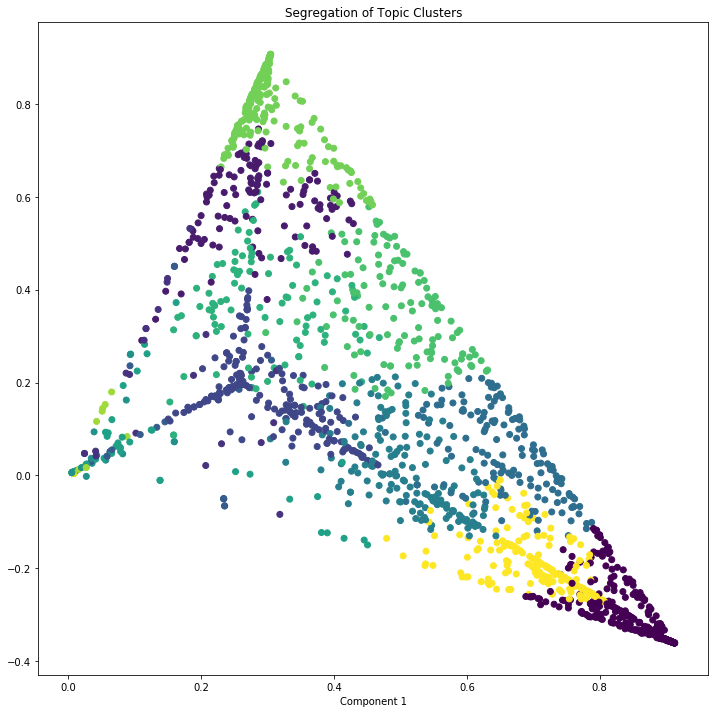

In [166]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

In [167]:
from sklearn.metrics.pairwise import euclidean_distances

nlp = spacy.load('en', disable=['parser', 'ner'])

def similar_documents(text, doc_topic_probs, documents = data, nlp=nlp, top_n=5, verbose=False):
    topic, x  = predict_topic(text)
    dists = euclidean_distances(x.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dists)[:top_n]
    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)

In [192]:
# Get similar documents
mytext = [str(input())]
doc_ids, docs = similar_documents(text=mytext, doc_topic_probs=lda_output, documents = data, top_n=1, verbose=True)

song_rec = genius.get_song(all_trax_df[all_trax_df['annotations'].str.contains(docs[0])].index[0])
print('track: '+ song_rec['song']['title'])
print('artist: ' + song_rec['song']['primary_artist']['name'])

Kendrick evokes religious imagery—he calls out for everyone to gather around him, much like a preacher does, and he even dresses like a pope in the music video. The theme “wicked or weakness” is first heard on the intro track, “BLOOD.,” where Kendrick implores his listeners to determine whether his actions or the actions of his opponents are a sign of wickedness or weakness.  On “XXX.,” Kendrick has a friend who requests prayer after a fucked up day:  He said: “K.Dot, can you pray for me? It’s been a fucked up day for me  “Nobody pray for me,” is likely a proclamation, rather than a command. On “ELEMENT.,” Kendrick says:  Bitch, all my grandmas dead So ain’t nobody prayin' for me
Topic KeyWords:  ['use', 'line', 'say', 'make', 'reference', 'people', 'refer', 'know', 'rap', 'black', 'song', 'time', 'money', 'rapper', 'mean']
Topic Prob Scores of text:  [[0.  0.  0.2 0.1 0.  0.2 0.  0.6 0.  0. ]]
Most Similar Doc's Probs:   [[0.  0.  0.2 0.2 0.  0.  0.  0.6 0.  0. ]]


IndexError: index 0 is out of bounds for axis 0 with size 0

In [173]:
all_trax_df[all_trax_df['annotations'].str.contains(docs[0])].index[0]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


IndexError: index 0 is out of bounds for axis 0 with size 0